# jaxsde with jnn

In [529]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union,NamedTuple
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

#import diffrax
#import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, jit, vmap, value_and_grad
import optax



from jaxsde.sdeint import sdeint_ito

In [530]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [531]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x):
        if self._val is None:
            self._val = x
        else:
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [532]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = jnp.where(jnp.absolute(b)> epsilon, b, jnp.full_like(b, fill_value=epsilon)*jnp.sign(b))
    return a/b

In [533]:

batch_size = 256

## 5. Simulation of time series

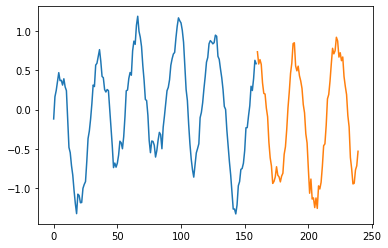

In [534]:
T = 240
t_end = 24.
t_start = 1.
t = np.linspace(t_start,t_end,T)

gap = 160
s = 30
mu = 0
sigma = 0.1
phi = 0.9
def make_time_series():
    z0 = np.random.normal(0,sigma,1)
    z = np.zeros(T)
    z[0] = z0
    shocks = np.random.normal(mu, sigma, T)
    for idx in range(T-1):
        idx_t = t[idx]
        z[idx+1] = phi*z[idx] + shocks[idx] + 0.2*np.sin(2*10*np.pi*(idx_t)/s)
    return z
r = make_time_series()
r_train = r[:gap]
r_test = r[gap:]
plt.plot(range(gap),r_train)
plt.plot(range(gap,T),r_test)
plt.show()


In [535]:
@jit
def make_data():
    ts_ = jnp.array(t)
    ts_ext_ = jnp.array([t_start-0.1] + list(ts_) + [t_end+0.1])
    ts_vis_ = jnp.linspace(t_start,t_end, 1000)
    ys_ = jnp.array(r)
    return ts_, ts_ext_, ts_vis_, ys_

Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=2/3)>
(240, 2)


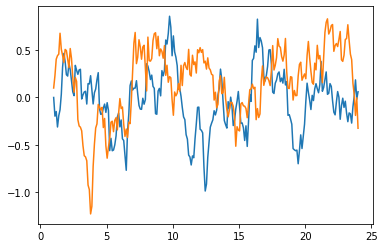

In [536]:
def g(y,t,args):  # Shared diffusion.
        return jnp.array([0.5])

def h(y,t,args):  # Prior drift.
    print(y)
    return 1. * (0. - y)
key = jrandom.PRNGKey(1)
t = np.linspace(t_start,t_end,T)
y0 = jnp.array([0.,0.1])
ys = sdeint_ito(h,g,y0,t,key,dt=0.01)
print(ys.shape)
plt.plot(t,ys)

In [537]:
seed=0

key = jrandom.PRNGKey(1)
class Constant(NamedTuple):
    theta: float
    mu: float
    sigma: float
    py0_mean: jnp.array
    py0_logvar: jnp.array




def init_MLP(layer_widths, parent_key, scale=0.01,theta=1.0,mu=0.,sigma=1.0):
    logvar = jnp.log(sigma**2/(2.*theta))
    params = []
    params.append([jnp.array([[mu]]),jnp.array([[logvar]])])
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params, Constant(theta,mu,sigma,jnp.array([[mu]]),jnp.array([[logvar]]))

# test
key = jax.random.PRNGKey(seed)
params, variables= init_MLP([5,200,200,1], key)
print(jax.tree_map(lambda x: x.shape, params))
print(variables)

[[(1, 1), (1, 1)], [(200, 5), (200,)], [(200, 200), (200,)], [(1, 200), (1,)]]
Constant(theta=1.0, mu=0.0, sigma=1.0, py0_mean=DeviceArray([[0.]], dtype=float32), py0_logvar=DeviceArray([[-0.6931472]], dtype=float32))


In [570]:
def loss(variables,params,ts,ys,key):
    #zs, kl = forward(ts,batch_size,variables,params,key)
    forward(ts,batch_size,variables,params,key)
    zs = jnp.squeeze(zs)
    zs = zs[1:-1] 
    logpy = jax.scipy.stats.norm.logpdf(ys,loc=zs,scale=0.0001).sum(axis=0).mean(axis=0)
    loss = -logpy + kl * kl_scheduler.val
    return loss

def forward(ts, batch_size,variables,params,key):
    theta, mu, sigma,py0_mean,py0_logvar = variables
    def f(y,t,args):
        x = jnp.array([jnp.sin(t),jnp.cos(t),jnp.sin(t**2),jnp.cos(t**2),y])
        for w,b in params[1:-1]:
            x = jax.nn.relu(jnp.dot(w,x)+b)
        w_last,b_last = params[-1]
        x = jnp.dot(w_last,x)+b_last
        print("f's x",x.shape)
        return x


    def g(y,t,args):  # Shared diffusion.
        res = jnp.array([y*sigma])
        print("g",res.shape)
        return res
    def h(y,t,args):  # Prior drift.
        res = jnp.array([theta * (mu - y)])
        print("h",res.shape)
        return res

    def f_aug(y,t,args):  # Drift for augmented dynamics with logqp term.
        y = y[0]
        fv, gv, hv = f(y,t,args),g(y,t,args),h(y,t,args)
        u = _stable_division(fv-hv,gv)
        f_logqp = .5*(u**2)
        res = jnp.concatenate([fv,f_logqp])
        print("f_aug",res.shape)
        return res

    
    def g_aug(y,t,args):  # Diffusion for augmented dynamics with logqp term.
        y=y[0]
        gv = g(y,t,args)
        g_logqp = jnp.zeros_like(jnp.array([y]))
        res = jnp.concatenate([gv,g_logqp])
        print("g_aug",res)
        return res

    dt0 = 0.01
    
    py0_std = jnp.exp(.5 * py0_logvar)
    qy0_mean = params[0][0]
    qy0_std = jnp.exp(.5*params[0][1])
    eps_key,bm_key = jrandom.split(key,2)
    eps = jrandom.normal(key=eps_key,shape=(batch_size,1))
    y0 = qy0_mean + eps * qy0_std
    logqp0 = jnp.log(qy0_std/py0_std+(py0_std**2+(py0_mean-qy0_mean)**2)/(2*qy0_std**2)-0.5)
    logqp0 = logqp0.sum(axis=1)
    aug_y0 = jnp.concatenate([y0, jnp.zeros((batch_size,1))],axis=1)
    print("aug_y0",aug_y0.shape)
    def integrate(y):
        print("y",y.shape)
        ys = sdeint_ito(f_aug,g_aug, y, ts, bm_key, dt=dt0)
    ys = jit(vmap(integrate))(aug_y0)
    print("ys",ys.shape)
    #ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
    #logqp = (logqp0+logqp_path).mean()
    return ys#, logqp
def sample_p(ts, batch_size,variables,params,eps,key):
    theta, mu, sigma, py0_mean,py0_logvar = variables
    
    def g(y,t,args):  # Shared diffusion.
        #res = jnp.ones((1,jnp.size(y,1)))*sigma
        #return res
        print(y)
        return jnp.array([sigma])

    def h(y,t,args):  # Prior drift.
        print(y)
        res = theta * (mu - y)
        return res
    
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    py0_mean = params[0][1]
    py0_std = jnp.exp(.5*params[0][1])
    eps_key,bm_key = jrandom.split(key,2)
    y0 = py0_mean + eps * py0_std
    ys = sdeint_ito(h, g, y0, ts, bm_key, dt=0.01)
    return ys

def sample_q(ts, batch_size, variables,params,eps,key):
    theta, mu, sigma, py0_mean,py0_logvar = variables
    def f(y,t,args):
        t = jnp.full_like(y, t)
        x = jnp.concatenate((jnp.sin(t),jnp.cos(t),jnp.sin(t**2),jnp.cos(t**2),y),axis=0)
        def predict(x):
            for w,b in params[1:-1]:
                x = jax.nn.relu(jnp.dot(w,x)+b)
            w_last,b_last = params[-1]
            x = jnp.dot(w_last,x)+b_last
            return x
        res=vmap(predict,in_axes=(1))(x)
        return jnp.transpose(res)


    def g(y,t,args):  # Shared diffusion.
        res = jnp.ones((1,jnp.size(y,1)))*sigma
        return res
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    qy0_mean = params[0][1]
    qy0_std = jnp.exp(.5*params[0][1])
    y0 = qy0_mean + eps * qy0_std
    ys = sdeint_ito(f, g, y0, ts, bm_key,dt=0.01)
    return ys

In [571]:
def update(variables,params, ts, ys, opt_sgd,opt_state,key):
    value, grads = value_and_grad(loss)(variables,params,ts,ys,key)
    updates, opt_state = opt_sgd.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

In [572]:
def main(num_epochs=500):
    
    
    ts, ts_ext, ts_vis, ys = make_data()
    init_key,p_key,eps_key, bm_key,per_key,k1 = jrandom.split(key,6)
    params, variables= init_MLP([5,200,200,1], init_key)
    opt_sgd = optax.sgd(learning_rate=0.01)
    opt_state = opt_sgd.init(params)
    kl_scheduler = LinearScheduler(iters=100)

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()
    vis_batch_size = 1024
    ylims = (-1., 1.)
    
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = jrandom.permutation(key=per_key,x=vis_batch_size)
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
    eps = jrandom.normal(key=eps_key,shape=(1,vis_batch_size))

    sigma = jnp.std(ys)
    
    # plot prior
    zs = sample_p(ts_vis,batch_size,variables,params,eps,p_key).squeeze()
    zs = jnp.sort(zs,axis=1)
    plt.subplot(frameon=False)
    '''
    for alpha, percentile in zip(alphas, percentiles):
        idx = int((1 - percentile) / 2. * vis_batch_size)
        zs_bot = zs[:, idx]
        zs_top = zs[:, -idx]
        
        plt.fill_between(ts_vis, zs_bot, zs_top, alpha=alpha, color=fill_color)
    '''
    
    plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
    plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
    plt.plot(ts_vis,zs.mean(axis=1),color='r')
    #plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
    plt.ylim(ylims)
    plt.xlabel('$t$')
    plt.ylabel('$Y_t$')
        
    plt.tight_layout()
    plt.legend()
    #plt.savefig('./img_diffrax/prior.png', dpi=300)
    plt.show()
    plt.close()

    
    for epoch in range(num_epochs):
        if (epoch+1) % 10 == 0:
            img_path = os.path.join("./img_diffrax/", f'global_step_{epoch+1}.png')
            zs = sample_q(ts_vis,batch_size,variables,params,eps,p_key).squeeze()
            plt.plot(ts_vis, zs.mean(axis=1), color='r',label=r'mean of latent variables')
            plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
            #plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')

            plt.tight_layout()
            plt.legend()
            #plt.savefig(img_path, dpi=300)
            plt.show()
            plt.close()
        start_time = time.time()
        opt_state, params = update(variables,params, ts_ext,ys, opt_sgd,opt_state,k1)
        
        loss_metric.step(loss)
        kl_scheduler.step()
        epoch_time = time.time()-start_time
        print("Epoch {} | T: {:0.2f} | loss {:0.3f}".format(epoch+1,epoch_time,loss))
        



Traced<ShapedArray(float32[1,1024])>with<DynamicJaxprTrace(level=2/3)>
Traced<ShapedArray(float32[1,1024])>with<DynamicJaxprTrace(level=2/3)>
Traced<ShapedArray(float32[1,1024])>with<DynamicJaxprTrace(level=2/3)>
Traced<ShapedArray(float32[1,1024])>with<JVPTrace(level=3/3)> with
  primal = Traced<ShapedArray(float32[1,1024])>with<DynamicJaxprTrace(level=2/3)>
  tangent = Traced<ShapedArray(float32[1,1024])>with<DynamicJaxprTrace(level=2/3)>


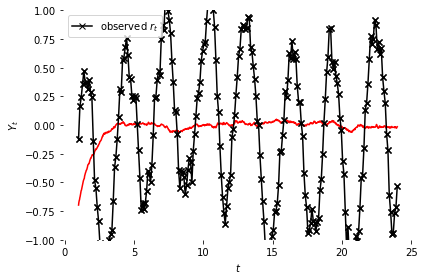

aug_y0 (256, 2)
y (2,)
f's x (1,)
g (1,)
h (1,)
f_aug (2,)
g (1,)
g_aug Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/4)>
g (1,)
g_aug Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/4)>
g (1,)
g_aug Traced<ShapedArray(float32[2])>with<JVPTrace(level=6/4)> with
  primal = Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/4)>
  tangent = Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/4)>


CustomVJPException: Detected differentiation of a custom_vjp function with respect to a closed-over value. That isn't supported because the custom VJP rule only specifies how to differentiate the custom_vjp function with respect to explicit input parameters. Try passing the closed-over value into the custom_vjp function as an argument, and adapting the custom_vjp fwd and bwd rules.

In [573]:
logging.getLogger().setLevel(logging.INFO)

main()